In [1]:
import paddle
import paddle.fluid as fluid
import numpy
import sys
#paddle.__version__
# pip install --upgrade paddlepaddle

In [2]:
# pip install --upgrade paddlepaddle

In [3]:
def vgg_bn_drop(input): # Define conv and pooling method
    def conv_block(ipt, num_filter, groups, dropouts):
        return fluid.nets.img_conv_group(
            input=ipt,
            pool_size=2, # pool size 2
            pool_stride=2, # pool stride 2
            conv_num_filter=[num_filter] * groups, # filter number
            conv_filter_size=3, # kernel size 3
            conv_act='relu', # relu
            conv_with_batchnorm=True, # normalization
            conv_batchnorm_drop_rate=dropouts, # dropouts overfitting, hide part of the neurons, better results
            pool_type='max') # max pooling

    conv1 = conv_block(input, 64, 2, [0.3, 0]) # first layer
    conv2 = conv_block(conv1, 128, 2, [0.4, 0]) # second layer
    conv3 = conv_block(conv2, 256, 3, [0.4, 0.4, 0])
    conv4 = conv_block(conv3, 512, 3, [0.4, 0.4, 0])
    conv5 = conv_block(conv4, 512, 3, [0.4, 0.4, 0])

    drop = fluid.layers.dropout(x=conv5, dropout_prob=0.5)
    fc1 = fluid.layers.fc(input=drop, size=512, act=None)
    bn = fluid.layers.batch_norm(input=fc1, act='relu')
    drop2 = fluid.layers.dropout(x=bn, dropout_prob=0.5)
    fc2 = fluid.layers.fc(input=drop2, size=512, act=None)
    predict = fluid.layers.fc(input=fc2, size=10, act='softmax')
    return predict
# VGG 16

### Train program

In [4]:
def inference_program():
    # The image is 32 * 32 with RGB representation.
    data_shape = [None, 3, 32, 32] # 3dimension, RGB
    images = fluid.layers.data(name='pixel', shape=data_shape, dtype='float32') # variable

#     predict = resnet_cifar10(images, 32)
    predict = vgg_bn_drop(images) # VGG 16
    return predict

In [5]:
def train_program():
    predict = inference_program()

    label = fluid.layers.data(name='label', shape=[None,1], dtype='int64')
    cost = fluid.layers.cross_entropy(input=predict, label=label) # cross entropy
    avg_cost = fluid.layers.mean(cost) # average cross entropy
    accuracy = fluid.layers.accuracy(input=predict, label=label) # accuracy
    return [avg_cost, accuracy, predict]

In [6]:
# adam optimizer
def optimizer_program():
    return fluid.optimizer.Adam(learning_rate=0.001)

!mkdir /home/jovyan/.cache/paddle/dataset/cifar  
!cp /home/jovyan/mnt/rd123/cifar-10-python.tar.gz /home/jovyan/.cache/paddle/dataset/cifar

In [7]:
# Each batch will yield 128 images
BATCH_SIZE = 128

# Reader for training
train_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.cifar.train10(), buf_size=50000),
    batch_size=BATCH_SIZE)

# Reader for testing. A separated data set for testing.
test_reader = paddle.batch(
    paddle.dataset.cifar.test10(), batch_size=BATCH_SIZE)

In [8]:
use_cuda = True
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()

feed_order = ['pixel', 'label']

main_program = fluid.default_main_program()
star_program = fluid.default_startup_program()

avg_cost, acc, predict = train_program()

# Test program
test_program = main_program.clone(for_test=True)

optimizer = optimizer_program()
optimizer.minimize(avg_cost)

exe = fluid.Executor(place)

EPOCH_NUM = 2

# For test data loss and accuracy:
def train_test(program, reader):
    count = 0
    feed_var_list = [
        program.global_block().var(var_name) for var_name in feed_order
    ]
    feeder_test = fluid.DataFeeder(
        feed_list=feed_var_list, place=place)
    test_exe = fluid.Executor(place)
    accumulated = len([avg_cost, acc]) * [0]
    for tid, test_data in enumerate(reader()):
        avg_cost_np = test_exe.run(program=program,
                                   feed=feeder_test.feed(test_data),
                                   fetch_list=[avg_cost, acc])
        accumulated = [x[0] + x[1][0] for x in zip(accumulated, avg_cost_np)]
        count += 1
    return [x / count for x in accumulated]

In [9]:
params_dirname = "image_classification_resnet.inference.model"

from paddle.utils.plot import Ploter

train_prompt = "Train cost"
test_prompt = "Test cost"
plot_cost = Ploter(test_prompt,train_prompt)

In [10]:
# main train loop.
def train_loop():
    feed_var_list_loop = [
        main_program.global_block().var(var_name) for var_name in feed_order
    ]
    feeder = fluid.DataFeeder(
        feed_list=feed_var_list_loop, place=place)
    exe.run(star_program)

    step = 0
    for pass_id in range(EPOCH_NUM):
        for step_id, data_train in enumerate(train_reader()):
            avg_loss_value = exe.run(main_program,
                                     feed=feeder.feed(data_train),
                                     fetch_list=[avg_cost, acc])
            if step % 1 == 0:
                plot_cost.append(train_prompt, step, avg_loss_value[0])
                plot_cost.plot()
            step += 1

# test dataset
        avg_cost_test, accuracy_test = train_test(test_program,
                                                  reader=test_reader)
        plot_cost.append(test_prompt, step, avg_cost_test)

        # save parameters
        if params_dirname is not None:
            fluid.io.save_inference_model(params_dirname, ["pixel"],
                                          [predict], exe)

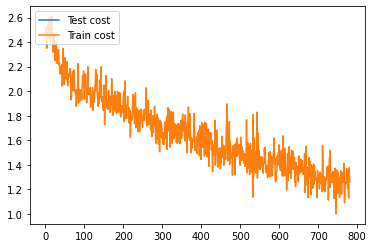

<Figure size 432x288 with 0 Axes>

In [11]:
train_loop()